In [59]:
import matplotlib.pyplot as plt

<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

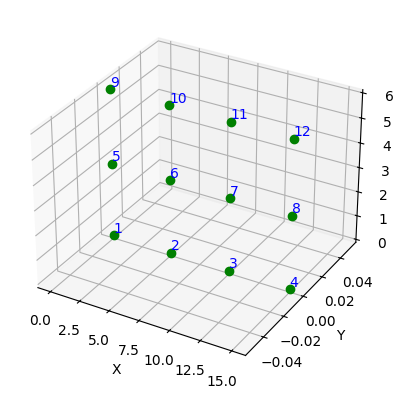

In [60]:
import openseespy.opensees as ops
import opsvis as opsv
import matplotlib.pyplot as plt
# Clear existing model
ops.wipe()

# Define Model Builder
ops.model('basic', '-ndm', 3, '-ndf', 6)  # 3D model with 6 DOF per node

# Define parameters
n = 3        # Number of bays
l = 5.0      # Length of each bay
h = 3.0      # Height of each story
numStories = 2  # Number of stories

# Material properties
bfoot = 10
dfoot = 1
E = 200e9  # Young's Modulus in Pa
A = bfoot * dfoot   # Area of the element in m^2
EoverG = 0.001
G = E/EoverG
Iy = bfoot * dfoot**3/12
Iz = dfoot**3 * bfoot/12  # Moment of Inertia in m^4
J = Iy + Iz

# Create nodes
for i in range(numStories + 1):
    for j in range(n + 1):
        nodeTag = i * (n + 1) + j + 1
        x = j * l
        z = i * h
        ops.node(nodeTag, x, 0, z)

# Define geometric transformation
horizontal_gTTag = 1
vertical_gTTag = 2
ops.geomTransf('Linear', horizontal_gTTag, 0, 1, 0)
ops.geomTransf('Linear', vertical_gTTag, 0, 1, 0)
opsv.plot_model()


<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

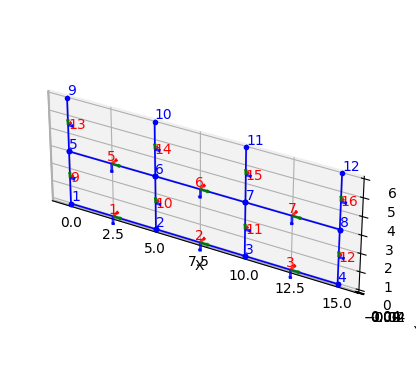

In [61]:
# Define elements
for i in range(numStories):
    for j in range(n):
        # Horizontal elements (beams)
        nodeI = i * (n + 1) + j + 1
        nodeJ = nodeI + 1
        eleTag = i * (n + 1) + j + 1
        ops.element('elasticBeamColumn', eleTag, nodeI, nodeJ, A, E, G, J, Iy, Iz, horizontal_gTTag)

    for j in range(n + 1):
        if i < numStories:
            # Vertical elements (columns)
            nodeI = i * (n + 1) + j + 1
            nodeJ = nodeI + (n + 1)
            eleTag = (i + numStories) * (n + 1) + j + 1
            ops.element('elasticBeamColumn', eleTag, nodeI, nodeJ, A, E, G, J, Iy, Iz, vertical_gTTag)
opsv.plot_model()
# sfac = opsv.plot_defo()

WARNING FullGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 362
WARNING NewtonRaphson::solveCurrentStep() -the LinearSysOfEqn failed in solve()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 0.1
OpenSees > analyze failed, returned: -3 error flag


<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

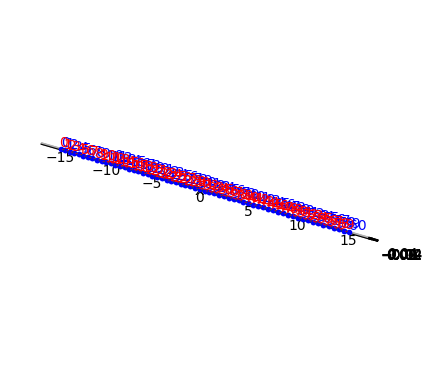

In [68]:
import numpy as np
# Import OpenSeesPy
from openseespy.opensees import *

# Wipe existing model
ops.wipe()

# Define the model builder
ops.model('basic', '-ndm', 3, '-ndf', 6)  # 3D model with 6 DOF per node

# Define nodes
beamX = np.linspace(-15, 15, 61)
nodeTag = 0
for i, x in enumerate(beamX):
    ops.node(i, x, 0.0, 0.0)

# Define boundary conditions
# fix(1, 1, 1, 1)
# fix(3, 1, 1, 0)

# Material properties
bfoot = 10
dfoot = 0.12
E = 70e9  # Young's Modulus in Pa
A = bfoot * dfoot   # Area of the element in m^2
EoverG = 2.6
G = E/EoverG
Iy = dfoot**3 * bfoot/12
Iz = bfoot**3 * dfoot/12  # Moment of Inertia in m^4
J = Iy + Iz

# Define coord transfer
horizontal_gTTag = 1
vertical_gTTag = 2
ops.geomTransf('Linear', horizontal_gTTag, 0, 0, 1)

# Define elements
for i in range(beamX.size - 1):
    # ops.element('elasticBeamColumn', i, i, i+1, A, E, G, J, Iy, Iz, horizontal_gTTag)
    ops.element('ElasticTimoshenkoBeam', i, i, i+1, E, G, A, J, Iy, Iz, bfoot*dfoot, bfoot*dfoot,horizontal_gTTag)

# Define constraints and analysis
ops.constraints('Plain')
ops.numberer('RCM')
ops.system('FullGeneral')
ops.test('NormDispIncr', 1.0e-6, 10)
ops.algorithm('Newton')
ops.integrator('LoadControl', 0.1)
ops.analysis('Static')

# Perform the analysis
ops.analyze(1)

# Print the global stiffness matrix
# ops.printA()

# Optional: Print the stiffness matrix to a file

K = ops.printA('-ret')
opsv.plot_model()

In [69]:
N = ops.systemSize() # Has to be done after analyze
K = np.array(K)
K.shape = (N,N)
print(K)

[[1.68000000e+11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.45533141e+10 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.41636515e+09 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.38539077e+11
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  7.27622822e+08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.40403458e+12]]


In [70]:
np.savetxt('opensees_K.txt', K, fmt = '%.4e')

In [71]:
L = beamX[1] - beamX[0]
print(12*E*Iz/L**3 * 1e-13)
print(G*J/L)

6.720000000000001
538539076923.07697


In [72]:
EoverG = 2.6
ni_str = EoverG/2 - 1
k = 10 * (1 + ni_str) / (12 + 11 * ni_str)
phi3 = 12 * E * Iz / k / G / A / (L * L)
phi3Bar = 1/(1+phi3)
print(phi3Bar)
12 * E * Iz * phi3Bar/ pow(L, 3)

0.0008163265306122449


np.float64(54857142857.14286)

: 

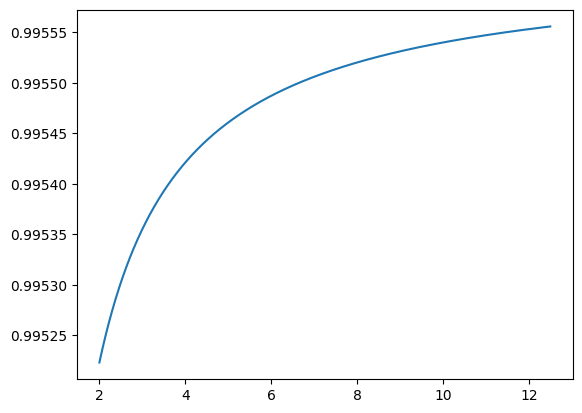

In [29]:
EoverG = np.linspace(2, 12.5, 1000)
bfoot = 10
dfoot = 50
A = bfoot * dfoot   # Area of the element in m^2
Iy = dfoot**3 * bfoot/12
Iz = bfoot**3 * dfoot/12  # Moment of Inertia in m^4
ni_str = EoverG/2 - 1
k = 10 * (1 + ni_str) / (12 + 11 * ni_str)
phi3 = 12 * E * Iz / k / G / A / (L * L)
phi3Bar = 1/(1+phi3)
plt.plot(EoverG, phi3Bar)


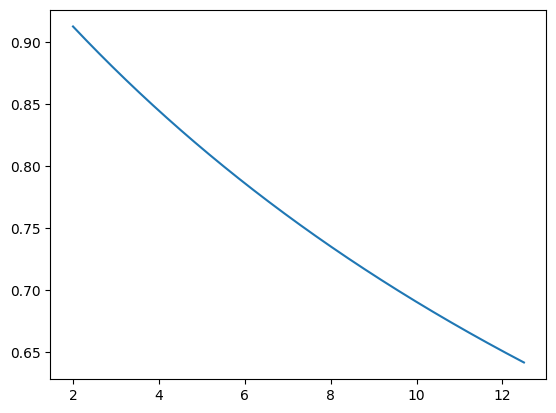

In [58]:
EoverG = np.linspace(2, 12.5, 1000)
ni_str = EoverG/2 - 1
k = 10 * (1 + ni_str) / (12 + 11 * ni_str)
bfoot = 10
dfoot = 1
L = 5
A = bfoot * dfoot   # Area of the element in m^2
Iy = dfoot**3 * bfoot/12
Iz = bfoot**3 * dfoot/12  # Moment of Inertia in m^4
phi2 = 12 * EoverG * Iy / k / A / (L * L)
phi2Bar = 1/(1+phi2)
plt.plot(EoverG, phi2Bar)

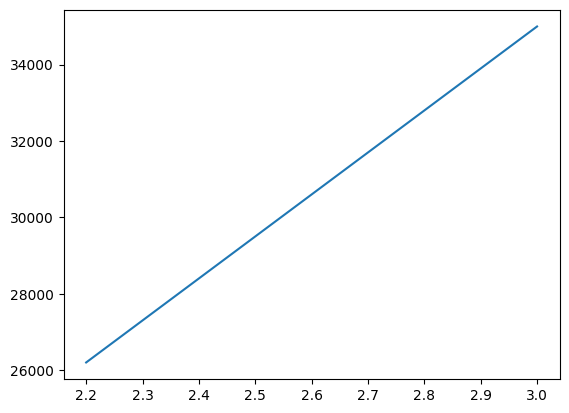

In [54]:
EoverG = np.linspace(2.2, 3, 1000)
ni_str =  EoverG/2 - 1
G = E/EoverG
k = 10 * (1 + ni_str) / (12 + 11 * ni_str)
phi2 = 12 * EoverG * Iy / k / A / (L * L)
plt.plot(EoverG, phi2)